<a href="https://colab.research.google.com/github/Elshraby/DeepAerofoil/blob/main/AeroDyn_Model04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Regression Model


In [ ]:
import torch
from torch import nn
print(f"Torch version: {torch.__version__}")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Torch version: 2.4.1+cu121
Using device: cpu


In [ ]:
import requests
import zipfile
from pathlib import Path

# Download Airfoils data
with open("Airfoils.zip", "wb") as f:
    request = requests.get("https://github.com/Elshraby/meine-repo/raw/refs/heads/main/data/Airfoils.zip")
    print("Downloading Airfoils Data...")
    f.write(request.content)

# Unzip Airfoil data
with zipfile.ZipFile("Airfoils.zip", "r") as zip_ref:
    print("Unzipping airfoils data...")
    zip_ref.extractall()

Unzipping airfoils data...


In [ ]:
import pandas as pd
df = pd.read_csv('RegData.csv')
df.head()

,name,y_U1,y_U2,y_U3,y_U4,y_U5,y_U6,y_U7,y_U8,y_U9,...,y_L4,y_L5,y_L6,y_L7,y_L8,y_L9,angle,cd,cl,cm
0,2032c,0.078,0.1013,0.1048,0.1002,0.0905,0.0771,0.061,0.0428,0.0229,...,0.0385,0.0386,0.035,0.0286,0.0202,0.01,-8.75,0.09761,-0.1581,-0.0262
1,2032c,0.078,0.1013,0.1048,0.1002,0.0905,0.0771,0.061,0.0428,0.0229,...,0.0385,0.0386,0.035,0.0286,0.0202,0.01,-8.50,0.09468,-0.1536,-0.0262
2,2032c,0.078,0.1013,0.1048,0.1002,0.0905,0.0771,0.061,0.0428,0.0229,...,0.0385,0.0386,0.035,0.0286,0.0202,0.01,-8.25,0.10671,-0.2407,-0.0219
3,2032c,0.078,0.1013,0.1048,0.1002,0.0905,0.0771,0.061,0.0428,0.0229,...,0.0385,0.0386,0.035,0.0286,0.0202,0.01,-8.00,0.10247,-0.2303,-0.0213
4,2032c,0.078,0.1013,0.1048,0.1002,0.0905,0.0771,0.061,0.0428,0.0229,...,0.0385,0.0386,0.035,0.0286,0.0202,0.01,-7.75,0.09947,-0.2229,-0.0215


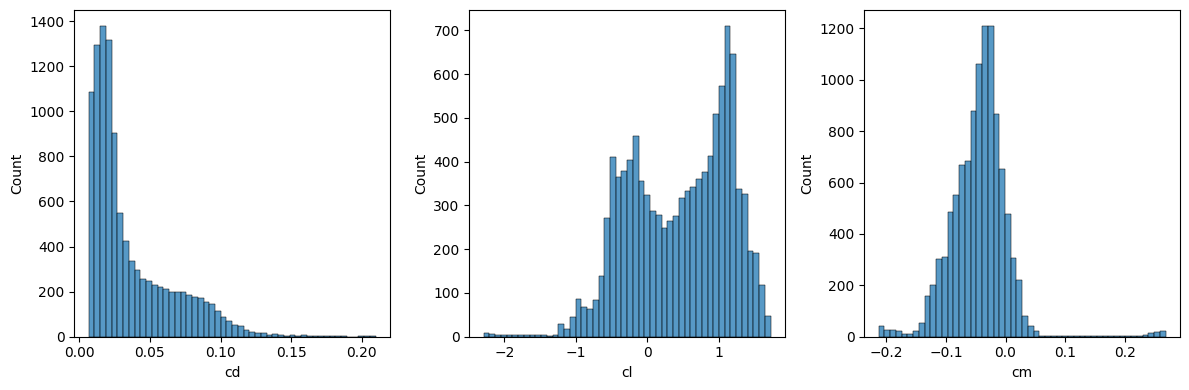

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(12, 4))

fig.add_subplot(1, 3, 1)
sns.histplot(df['cd'], bins=50)

fig.add_subplot(1, 3, 2)
sns.histplot(df['cl'], bins=50)

fig.add_subplot(1, 3, 3)
sns.histplot(df['cm'], bins=50)

plt.tight_layout()

In [ ]:
from sklearn.model_selection import train_test_split
# Define the features and target variables
features = ['y_U1', 'y_U2', 'y_U3', 'y_U4', 'y_U5', 'y_U6', 'y_U7', 'y_U8', 'y_U9',
            'y_L1', 'y_L2', 'y_L3', 'y_L4', 'y_L5', 'y_L6', 'y_L7', 'y_L8', 'y_L9',
            'angle']
targets = ['cl', 'cd', 'cm']

# Split the data into training, validation, and test sets
features_train, features_temp, targets_train, targets_temp = train_test_split(df[features], df[targets], test_size=0.3, random_state=42)
features_val, features_test, targets_val, targets_test = train_test_split(features_temp, targets_temp, test_size=0.5, random_state=42)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Prepare PyTorch datasets and loaders for the neural network
batch_size = 32
train_dataset = TensorDataset(torch.tensor(features_train.values, dtype=torch.float32),
                              torch.tensor(targets_train.values, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(torch.tensor(features_val.values, dtype=torch.float32),
                              torch.tensor(targets_val.values, dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
len(features)

19

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Neural Network for Regression
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(len(features), 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 3)  # Output size is 3 for 'cl', 'cd', and 'cm'

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize model, loss function, and optimizer
model = RegressionNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
# Neural Network Training
torch.manual_seed(42)

num_epochs = 500
model.train()
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Testing step
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
    val_loss /= len(val_loader)
    if epoch % 50 == 0:
      print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

Epoch 1/500, Validation Loss: 0.0139
Epoch 51/500, Validation Loss: 0.0033
Epoch 101/500, Validation Loss: 0.0012
Epoch 151/500, Validation Loss: 0.0011
Epoch 201/500, Validation Loss: 0.0009
Epoch 251/500, Validation Loss: 0.0007
Epoch 301/500, Validation Loss: 0.0008
Epoch 351/500, Validation Loss: 0.0007
Epoch 401/500, Validation Loss: 0.0006
Epoch 451/500, Validation Loss: 0.0006


In [ ]:
# Prepare test data and evaluate models
features_test_tensor = torch.tensor(features_test.values, dtype=torch.float32).to(device)
targets_test_tensor = torch.tensor(targets_test.values, dtype=torch.float32).to(device)

In [ ]:
# Make predictions
model.eval()
with torch.no_grad():
  targets_pred_nn = model(features_test_tensor)

In [ ]:
targets_pred_nn[:10]

tensor([[-0.5095,  0.0459, -0.0674],
        [-0.3580,  0.0264, -0.0341],
        [-0.8357,  0.0368, -0.0073],
        [ 0.1888,  0.0075, -0.0107],
        [ 0.2984,  0.0041, -0.0320],
        [ 0.8072,  0.0121, -0.0737],
        [ 0.8683,  0.0103, -0.0387],
        [ 1.2122,  0.0270, -0.0141],
        [ 0.9448,  0.0270, -0.0172],
        [ 0.8581,  0.0147, -0.0196]])

In [ ]:
# Compare first 10 model preds and test labels
print(f"Predictions: {targets_pred_nn[:10]}\nLabels: {targets_test_tensor[:10]}")

Predictions: tensor([[-0.5095,  0.0459, -0.0674],
        [-0.3580,  0.0264, -0.0341],
        [-0.8357,  0.0368, -0.0073],
        [ 0.1888,  0.0075, -0.0107],
        [ 0.2984,  0.0041, -0.0320],
        [ 0.8072,  0.0121, -0.0737],
        [ 0.8683,  0.0103, -0.0387],
        [ 1.2122,  0.0270, -0.0141],
        [ 0.9448,  0.0270, -0.0172],
        [ 0.8581,  0.0147, -0.0196]])
Labels: tensor([[-0.5229,  0.0507, -0.0612],
        [-0.3548,  0.0160, -0.0258],
        [-0.8025,  0.0248, -0.0110],
        [ 0.1874,  0.0084, -0.0109],
        [ 0.2896,  0.0077, -0.0305],
        [ 0.8089,  0.0117, -0.0793],
        [ 0.8789,  0.0148, -0.0433],
        [ 1.2402,  0.0235, -0.0223],
        [ 0.9407,  0.0257, -0.0159],
        [ 0.8508,  0.0144, -0.0237]])


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Calculate RMSE for regression model
rmse_nn = np.sqrt(mean_squared_error(targets_test_tensor, targets_pred_nn))
# R2 scores for Neural Network
r2_nn = r2_score(targets_test_tensor, targets_pred_nn)
print(f"RMSE for Neural Network: {rmse_nn}")
print(f"R2 Score for Neural Network: {r2_nn}")

RMSE for Neural Network: 0.023909611627459526
R2 Score for Neural Network: 0.9572330946216517


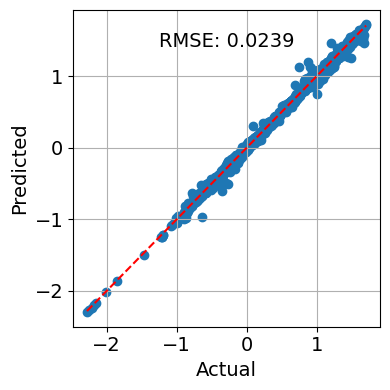

In [ ]:
# Visualization of results
fig, axs = plt.subplots(1, 1, figsize=(4, 4))
model_names = ['Neural Network']
predictions = [targets_pred_nn]
rmses = [rmse_nn]

letters = ['a']

for i in range(len(model_names)):
    axs.scatter(targets_test_tensor, predictions[i])
    axs.plot([targets_test_tensor.min(), targets_test_tensor.max()], [targets_test_tensor.min(), targets_test_tensor.max()], 'r--')
    axs.set_xlabel('Actual', fontsize=14)
    axs.set_ylabel('Predicted', fontsize=14)
    axs.tick_params(axis='both', labelsize=14)  # Set tick font size
    axs.text(0.5, 0.9, f"RMSE: {rmses[i]:.4f}", fontsize=14, ha='center', va='center', transform=axs.transAxes)
    axs.grid()

plt.tight_layout()
plt.show()

# Part 2: Visualization


In [ ]:
data = pd.read_csv('AirfoilsShape.csv')
data.head(100)

,name,x_coords,y_coords,y_U1
0,2032c,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.078000
1,a18,1.0 0.95 0.9 0.8 0.7 0.6 0.55 0.5 0.45 0.4 0.3...,0.00614 0.01817 0.02858 0.04624 0.06056 0.0719...,0.062340
2,a18sm,1.0 0.99754 0.9907 0.98037 0.96698 0.95044 0.9...,0.00307 0.00365 0.0053 0.00771 0.0107 0.01421 ...,0.043680
3,a63a108c,1.0 0.995 0.99 0.98 0.97 0.96 0.95 0.925 0.9 0...,0.007 0.007 0.0071 0.0073 0.0076 0.008 0.0086 ...,0.037090
4,ag03,1.0 0.994875 0.984975 0.973308 0.960939 0.9483...,0.000662 0.00121 0.002247 0.003426 0.004647 0....,0.040447
...,...,...,...,...
95,b707e,1.0 0.99 0.98 0.97 0.96 0.94 0.92 0.9 0.88 0.8...,0.0 0.001678 0.00335 0.005009 0.00665 0.009853...,0.041447
96,b737a,1.0 0.9109 0.8351 0.6488 0.5965 0.5593 0.5034 ...,0.0003 0.0132 0.0224 0.0498 0.0575 0.0626 0.06...,0.086600
97,b737b,1.0 0.9021 0.8266 0.7003 0.6001 0.5525 0.5101 ...,0.0004 0.0142 0.0233 0.0388 0.0512 0.0567 0.06...,0.066600
98,b737c,1.0 0.947 0.8741 0.6571 0.6091 0.5486 0.4904 0...,0.0005 0.0076 0.0183 0.0422 0.047 0.0529 0.059...,0.044100


In [ ]:
def string_to_floats(item: list | str, reverse = False):
    # List of floats to string
    if reverse:
      return ' '.join([str(x) for x in item])

    # String to list of floats
    return [float(x) for x in item.split()]

In [ ]:
data.loc[:, ['x_coords', 'y_coords']] = data[['x_coords', 'y_coords']].applymap(string_to_floats)

<ipython-input-18-2b9a8ddef3c6>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data.loc[:, ['x_coords', 'y_coords']] = data[['x_coords', 'y_coords']].applymap(string_to_floats)


In [ ]:
# Helper Functions

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Tuple
from pathlib import Path
from PIL import Image, ImageDraw

def airfoil_to_image(
    x: List[float], y: List[float], image_width: int = 384, image_height: int = 128
) -> np.ndarray:
    assert len(x) == len(y), "x and y must have the same length"
    normalized_coords = normalize_coordinates(x, y, image_width, image_height)
    img = create_white_image(image_width, image_height)
    draw_airfoil(img, normalized_coords)
    return (np.array(img) / 255).astype("float32")


def normalize_coordinates(x, y, image_width, image_height) -> List[Tuple[int, int]]:
    # Ensure x and y have the same length
    assert len(x) == len(y), "x and y must have the same length"

    # Calculate the minimum and maximum values of x and y
    x_min, x_max = min(x), max(x)
    y_min, y_max = min(y), max(y)

    # Calculate scaling factors for x and y separately
    x_scale = image_width / (x_max - x_min)
    y_scale = image_height / (y_max - y_min)

    # Use the smaller scale to ensure the entire airfoil fits
    scale = min(x_scale, y_scale)

    # Calculate the x and y offsets
    x_offset = (image_width - scale * (x_max - x_min)) / 2
    y_offset = (image_height - scale * (y_max - y_min)) / 2

    # Normalize the coordinates
    normalized_coords = [
        (int(x_offset + scale * (xi - x_min)), int(y_offset + scale * (yi - y_min)))
        for xi, yi in zip(x, y)
    ]

    return normalized_coords


def create_white_image(image_width: int, image_height: int) -> Image:
    return Image.new("L", (image_width, image_height), color=255)


def draw_airfoil(img: Image, normalized_coords: List[Tuple[int, int]]) -> None:
    draw = ImageDraw.Draw(img)
    draw.polygon(normalized_coords, fill=0)

In [ ]:
import concurrent
from cv2 import GaussianBlur

w = 300
h = 100
blur = 5

with concurrent.futures.ThreadPoolExecutor() as executor:
  futures_shape = [executor.submit(airfoil_to_image, row['x_coords'], row['y_coords'], w, h) for _, row in data.iterrows()]
  results_shape = [future.result() for future in futures_shape]

In [ ]:
data['shape'] = [GaussianBlur(x, (blur, blur), 0) for x in results_shape]

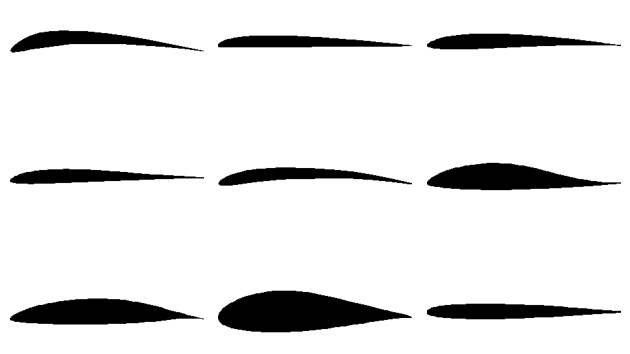

In [ ]:
# Plot a set of different airfoils
fig = plt.figure()
for i, airfoil in enumerate(results_shape[0:81:9]):
    fig.add_subplot(3, 3, i + 1)
    plt.imshow(airfoil[::-1], cmap = 'gray')
    plt.axis('off')
plt.tight_layout()

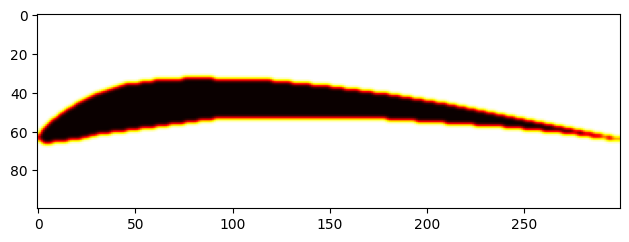

In [ ]:
# Plot airfoil with blurred edges
plt.imshow(data['shape'].iloc[0][::-1], cmap = 'hot')
plt.tight_layout()

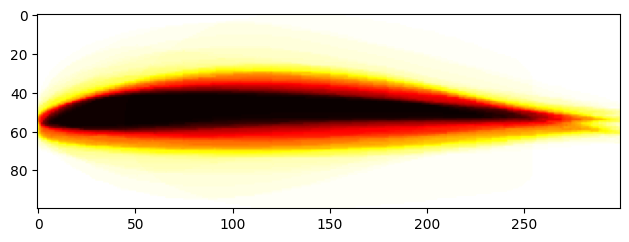

In [ ]:
# Plot average airfoil
avg_airfoil = np.mean(results_shape, axis = 0)
plt.imshow(avg_airfoil[::-1], cmap='hot')
plt.tight_layout()

#Part 3: CNN Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Step 1: Data Loading and Preprocessing
class AirfoilDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

        # Extract x, y coordinates
        self.x_coords = self.data['x_coords'].apply(lambda x: np.array(x.split()).astype(float)).tolist()
        self.y_coords = self.data['y_coords'].apply(lambda x: np.array(x.split()).astype(float)).tolist()

        # Extract target variables
        self.cl = self.data['cl'].values
        self.cd = self.data['cd'].values
        self.cm = self.data['cm'].values
        self.aoa = self.data['angle'].values

        # Normalize target variables
        self.scaler = MinMaxScaler()
        self.targets = self.scaler.fit_transform(np.column_stack((self.cl, self.cd, self.cm, self.aoa)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = np.array(self.x_coords[idx])
        y = np.array(self.y_coords[idx])

        # Create 2D image from x, y coordinates
        image = np.column_stack((x, y))
        image = image.reshape(1, len(x), 2)  # Dynamic sizing based on the number of points

        if self.transform:
            image = self.transform(image)

        return image, self.targets[idx]

# Custom collate function to handle variable-sized inputs
def collate_fn(batch):
    # Find the maximum number of points in the batch
    max_points = max(item[0].shape[1] for item in batch)

    # Pad each item to the maximum size
    padded_images = []
    targets = []
    for image, target in batch:
        pad_size = max_points - image.shape[1]
        padded_image = np.pad(image, ((0, 0), (0, pad_size), (0, 0)), mode='constant', constant_values=0)
        padded_images.append(padded_image)
        targets.append(target)

    # Stack the padded images and targets
    padded_images = np.stack(padded_images)
    targets = np.stack(targets)

    return torch.FloatTensor(padded_images), torch.FloatTensor(targets)

In [ ]:
# Step 2: Define the CNN Model
class AirfoilCNN(nn.Module):
    def __init__(self):
        super(AirfoilCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 4)  # 4 output variables: cl, cd, cm, aoa
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Step 3: Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses

Epoch [1/25], Train Loss: 0.0327, Val Loss: 0.0297
Epoch [2/25], Train Loss: 0.0258, Val Loss: 0.0252
Epoch [3/25], Train Loss: 0.0257, Val Loss: 0.0252
Epoch [4/25], Train Loss: 0.0261, Val Loss: 0.0253
Epoch [5/25], Train Loss: 0.0257, Val Loss: 0.0256
Epoch [6/25], Train Loss: 0.0255, Val Loss: 0.0246
Epoch [7/25], Train Loss: 0.0248, Val Loss: 0.0244
Epoch [8/25], Train Loss: 0.0248, Val Loss: 0.0244
Epoch [9/25], Train Loss: 0.0246, Val Loss: 0.0242
Epoch [10/25], Train Loss: 0.0244, Val Loss: 0.0249
Epoch [11/25], Train Loss: 0.0241, Val Loss: 0.0236
Epoch [12/25], Train Loss: 0.0240, Val Loss: 0.0242
Epoch [13/25], Train Loss: 0.0237, Val Loss: 0.0237
Epoch [14/25], Train Loss: 0.0237, Val Loss: 0.0234
Epoch [15/25], Train Loss: 0.0235, Val Loss: 0.0233
Epoch [16/25], Train Loss: 0.0232, Val Loss: 0.0230
Epoch [17/25], Train Loss: 0.0232, Val Loss: 0.0231
Epoch [18/25], Train Loss: 0.0231, Val Loss: 0.0230
Epoch [19/25], Train Loss: 0.0230, Val Loss: 0.0232
Epoch [20/25], Train 

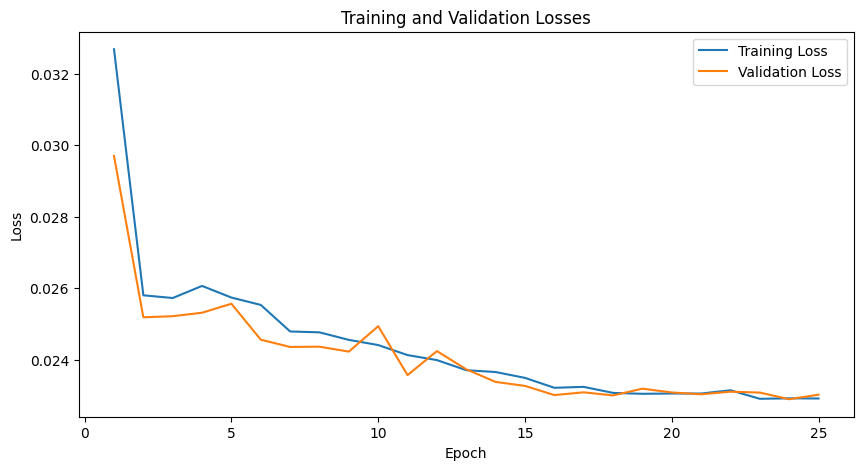

Mean Absolute Error:
CL: 0.5753
CD: 0.0243
CM: 0.0226
AoA: 6.4697


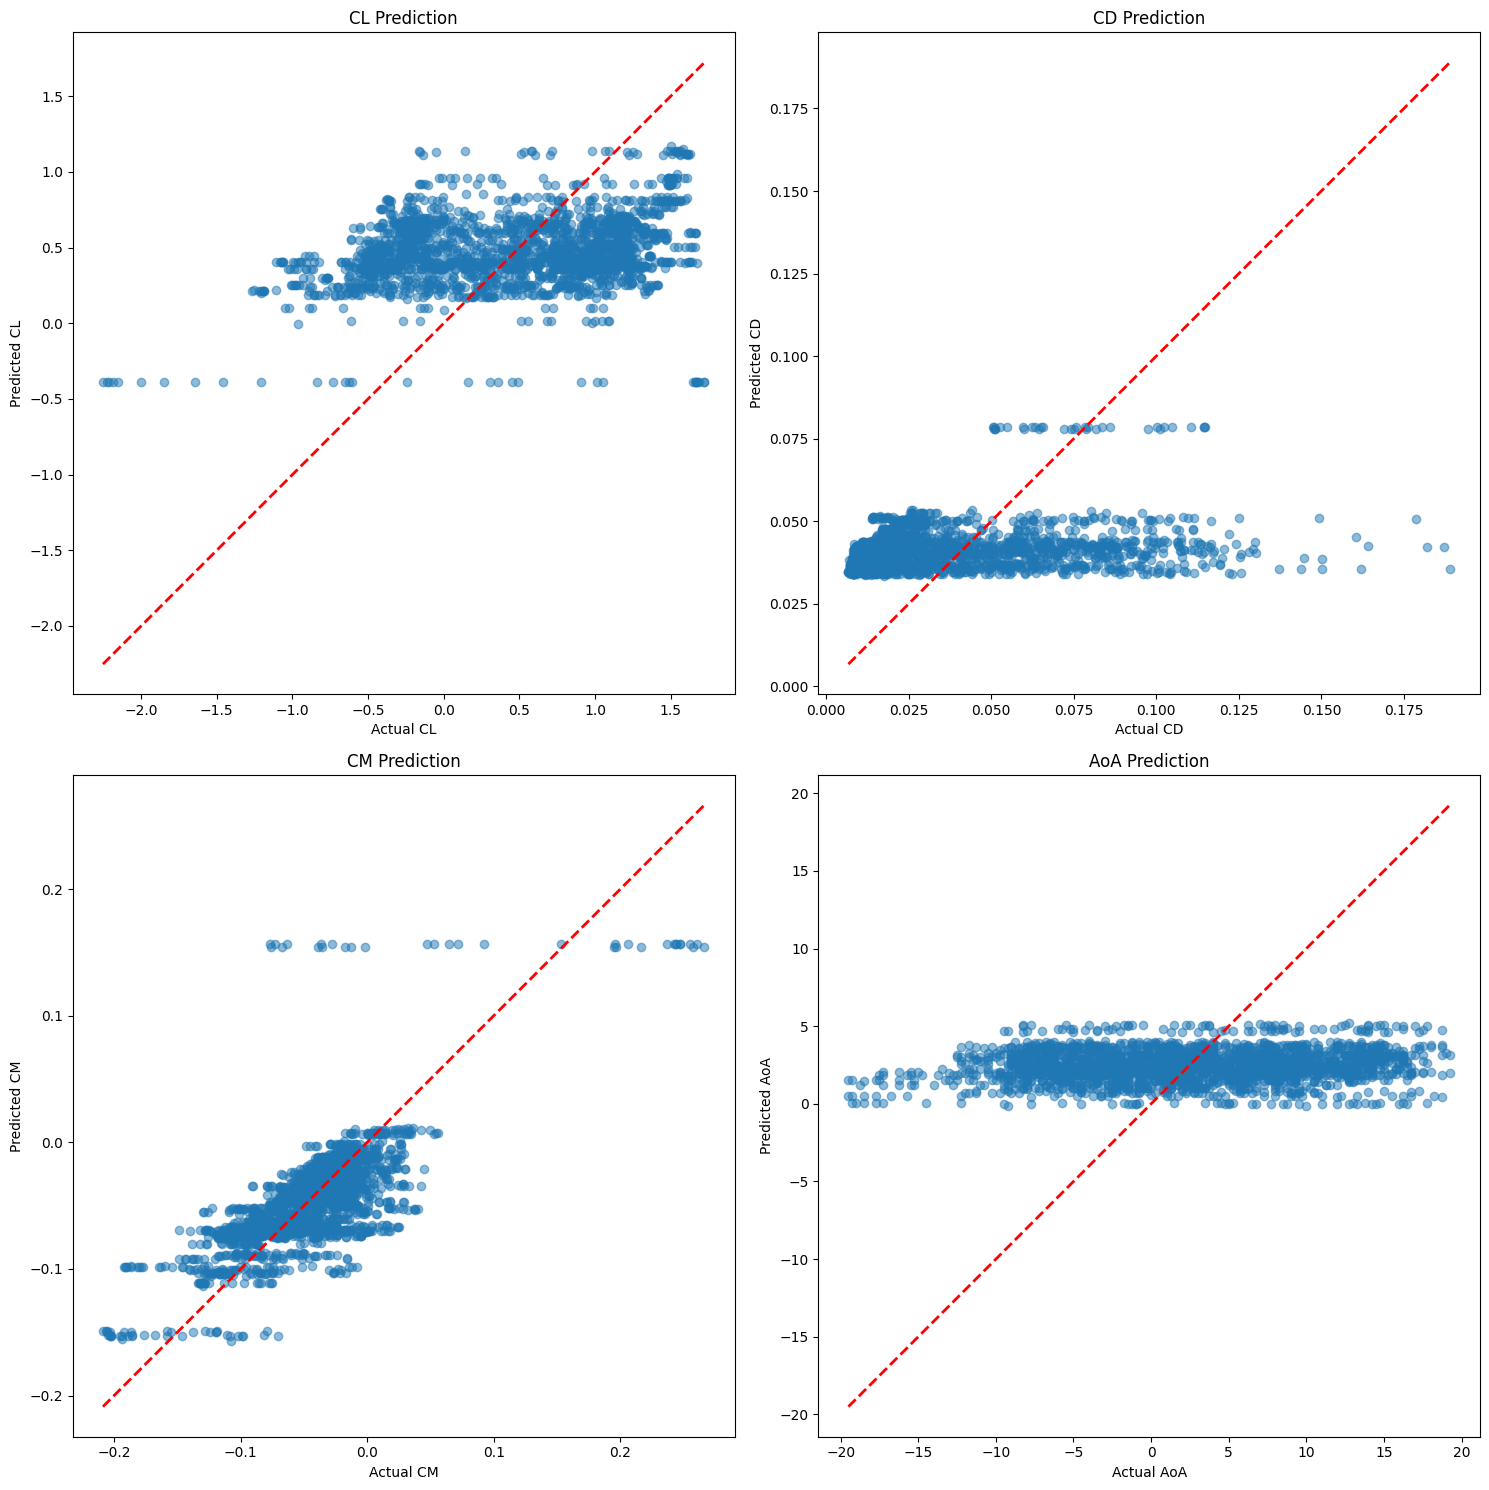

In [ ]:
# Step 4: Main Execution
if __name__ == "__main__":
    # Load and prepare data
    dataset = AirfoilDataset('ConvData.csv')
    train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=collate_fn)

    # Initialize model, loss function, and optimizer
    model = AirfoilCNN()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    num_epochs = 25
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

    # Step 5: Model Evaluation
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    # Denormalize predictions and targets
    all_predictions_denorm = dataset.scaler.inverse_transform(all_predictions)
    all_targets_denorm = dataset.scaler.inverse_transform(all_targets)

    # Calculate and print mean absolute error for each coefficient
    mae = np.mean(np.abs(all_predictions_denorm - all_targets_denorm), axis=0)
    print("Mean Absolute Error:")
    print(f"CL: {mae[0]:.4f}")
    print(f"CD: {mae[1]:.4f}")
    print(f"CM: {mae[2]:.4f}")
    print(f"AoA: {mae[3]:.4f}")

    # Plot predicted vs actual values for each coefficient
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    coeffs = ['CL', 'CD', 'CM', 'AoA']

    for i, ax in enumerate(axs.flat):
        ax.scatter(all_targets_denorm[:, i], all_predictions_denorm[:, i], alpha=0.5)
        ax.plot([all_targets_denorm[:, i].min(), all_targets_denorm[:, i].max()],
                [all_targets_denorm[:, i].min(), all_targets_denorm[:, i].max()],
                'r--', lw=2)
        ax.set_xlabel(f'Actual {coeffs[i]}')
        ax.set_ylabel(f'Predicted {coeffs[i]}')
        ax.set_title(f'{coeffs[i]} Prediction')

    plt.tight_layout()
    plt.show()

##Improving the CNN

In [ ]:
# Step 1: Data Loading and Preprocessing
class AirfoilDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

        # Extract x, y coordinates
        self.x_coords = self.data['x_coords'].apply(lambda x: np.array(x.split()).astype(float)).tolist()
        self.y_coords = self.data['y_coords'].apply(lambda x: np.array(x.split()).astype(float)).tolist()

        # Extract target variables
        self.cl = self.data['cl'].values
        self.cd = self.data['cd'].values
        self.cm = self.data['cm'].values
        self.aoa = self.data['angle'].values

        # Normalize target variables
        self.scaler = MinMaxScaler()
        self.targets = self.scaler.fit_transform(np.column_stack((self.cl, self.cd, self.cm, self.aoa)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
      x = np.array(self.x_coords[idx])
      y = np.array(self.y_coords[idx])

      # Create 2D image from x, y coordinates
      image = np.column_stack((x, y))
      image = image.reshape(1, len(x), 2)  # Dynamic sizing based on the number of points

      if self.transform:
          image = self.transform(image)

      return torch.FloatTensor(image), torch.FloatTensor(self.targets[idx])

In [ ]:
def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # Pad images to the maximum size in the batch
    max_len = max(img.shape[1] for img in images)
    padded_images = [torch.nn.functional.pad(img, (0, 0, 0, max_len - img.shape[1])) for img in images]

    # Stack the padded images and targets
    padded_images = torch.stack(padded_images)
    targets = torch.stack(targets)

    return padded_images, targets

In [ ]:
class ImprovedAirfoilCNN(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(ImprovedAirfoilCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveMaxPool2d((1, 1))  # Adaptive pooling
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)  # 4 output variables: cl, cd, cm, aoa
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        scheduler.step(val_loss)  # Update learning rate based on validation loss

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses

In [ ]:
# Main execution
from torch.optim.lr_scheduler import ReduceLROnPlateau

if __name__ == "__main__":
    # Load and prepare data
    dataset = AirfoilDataset('ConvData.csv')
    train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=collate_fn)

    # Initialize model, loss function, and optimizer
    model = ImprovedAirfoilCNN()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Added L2 regularization
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    # Train the model
    num_epochs = 25  # Increased number of epochs
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

    # Step 5: Model Evaluation
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    # Denormalize predictions and targets
    all_predictions_denorm = dataset.scaler.inverse_transform(all_predictions)
    all_targets_denorm = dataset.scaler.inverse_transform(all_targets)

    # Calculate and print mean absolute error for each coefficient
    mae = np.mean(np.abs(all_predictions_denorm - all_targets_denorm), axis=0)
    print("Mean Absolute Error:")
    print(f"CL: {mae[0]:.4f}")
    print(f"CD: {mae[1]:.4f}")
    print(f"CM: {mae[2]:.4f}")
    print(f"AoA: {mae[3]:.4f}")

    # Plot predicted vs actual values for each coefficient
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    coeffs = ['CL', 'CD', 'CM', 'AoA']

    for i, ax in enumerate(axs.flat):
        ax.scatter(all_targets_denorm[:, i], all_predictions_denorm[:, i], alpha=0.5)
        ax.plot([all_targets_denorm[:, i].min(), all_targets_denorm[:, i].max()],
                [all_targets_denorm[:, i].min(), all_targets_denorm[:, i].max()],
                'r--', lw=2)
        ax.set_xlabel(f'Actual {coeffs[i]}')
        ax.set_ylabel(f'Predicted {coeffs[i]}')
        ax.set_title(f'{coeffs[i]} Prediction')

    plt.tight_layout()
    plt.show()

Epoch [1/25], Train Loss: 0.0367, Val Loss: 0.0264
Epoch [2/25], Train Loss: 0.0290, Val Loss: 0.0255
Epoch [3/25], Train Loss: 0.0277, Val Loss: 0.0252
Epoch [4/25], Train Loss: 0.0270, Val Loss: 0.0257
Epoch [5/25], Train Loss: 0.0269, Val Loss: 0.0252
Epoch [6/25], Train Loss: 0.0264, Val Loss: 0.0252
Epoch [7/25], Train Loss: 0.0266, Val Loss: 0.0252
Epoch [8/25], Train Loss: 0.0264, Val Loss: 0.0252
Epoch [9/25], Train Loss: 0.0261, Val Loss: 0.0254
Epoch [10/25], Train Loss: 0.0261, Val Loss: 0.0253
Epoch [11/25], Train Loss: 0.0261, Val Loss: 0.0252


KeyboardInterrupt: 

## Another Model


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F  # Add this line
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

class AirfoilDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

        # Extract x, y coordinates
        self.x_coords = self.data['x_coords'].apply(lambda x: np.array(x.split()).astype(float)).tolist()
        self.y_coords = self.data['y_coords'].apply(lambda x: np.array(x.split()).astype(float)).tolist()

        # Extract input parameters
        self.aoa = self.data['angle'].values
        self.re = self.data['reynolds'].values

        # Extract target variables
        self.cl = self.data['cl'].values
        self.cd = self.data['cd'].values
        self.cm = self.data['cm'].values

        # Normalize input and target variables
        self.input_scaler = MinMaxScaler()
        self.input_params = self.input_scaler.fit_transform(np.column_stack((self.aoa, self.re)))

        self.output_scaler = MinMaxScaler()
        self.targets = self.output_scaler.fit_transform(np.column_stack((self.cl, self.cd, self.cm)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = np.array(self.x_coords[idx])
        y = np.array(self.y_coords[idx])

        # Create 2D image from x, y coordinates
        image = np.column_stack((x, y))
        image = image.reshape(1, len(x), 2)  # Dynamic sizing based on the number of points

        if self.transform:
            image = self.transform(image)

        input_params = self.input_params[idx]

        return image, input_params, self.targets[idx]

    def augment_data(self, x, y):
        # Add small random noise
        noise = np.random.normal(0, 0.001, x.shape)
        x += noise
        y += noise

        # Slightly rotate
        angle = np.random.uniform(-2, 2)
        rad = np.deg2rad(angle)
        rotation_matrix = np.array([[np.cos(rad), -np.sin(rad)],
                                    [np.sin(rad), np.cos(rad)]])
        rotated = np.dot(np.column_stack((x, y)), rotation_matrix)
        x, y = rotated[:, 0], rotated[:, 1]

        return x, y

def collate_fn(batch):
    images = [item[0] for item in batch]
    input_params = [item[1] for item in batch]
    targets = [item[2] for item in batch]

    # Pad images to the maximum size in the batch
    max_len = max(img.shape[1] for img in images)
    padded_images = [np.pad(img, ((0, 0), (0, max_len - img.shape[1]), (0, 0)), mode='constant') for img in images]

    # Stack the padded images, input parameters, and targets
    padded_images = np.stack(padded_images)
    input_params = np.stack(input_params)
    targets = np.stack(targets)

    return torch.FloatTensor(padded_images), torch.FloatTensor(input_params), torch.FloatTensor(targets)

In [ ]:
class ImprovedAirfoilCNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ImprovedAirfoilCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256 + 2, 128)  # +2 for AoA and Re
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3)  # 3 output variables: cl, cd, cm
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, params):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = torch.cat((x, params), dim=1)  # Concatenate AoA and Re
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, params, targets in train_loader:
            inputs, params, targets = inputs.to(device), params.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs, params)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, params, targets in val_loader:
                inputs, params, targets = inputs.to(device), params.to(device), targets.to(device)
                outputs = model(inputs, params)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses

In [ ]:
# Main execution
if __name__ == "__main__":
    # Load and prepare data
    dataset = AirfoilDataset('ConvData.csv')
    train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=collate_fn)

    # Initialize model, loss function, and optimizer
    model = ImprovedAirfoilCNN()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    # Train the model
    num_epochs = 100 # 30 epochs took more than 3 hours
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

    # Model Evaluation
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, params, targets in val_loader:
            inputs, params, targets = inputs.to(device), params.to(device), targets.to(device)
            outputs = model(inputs, params)
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    # Denormalize predictions and targets
    all_predictions_denorm = dataset.output_scaler.inverse_transform(all_predictions)
    all_targets_denorm = dataset.output_scaler.inverse_transform(all_targets)

    # Calculate and print mean absolute error for each coefficient
    mae = np.mean(np.abs(all_predictions_denorm - all_targets_denorm), axis=0)
    print("Mean Absolute Error:")
    print(f"CL: {mae[0]:.4f}")
    print(f"CD: {mae[1]:.4f}")
    print(f"CM: {mae[2]:.4f}")

    # Plot predicted vs actual values for each coefficient
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    coeffs = ['CL', 'CD', 'CM']

    for i, ax in enumerate(axs):
        ax.scatter(all_targets_denorm[:, i], all_predictions_denorm[:, i], alpha=0.5)
        ax.plot([all_targets_denorm[:, i].min(), all_targets_denorm[:, i].max()],
                [all_targets_denorm[:, i].min(), all_targets_denorm[:, i].max()],
                'r--', lw=2)
        ax.set_xlabel(f'Actual {coeffs[i]}')
        ax.set_ylabel(f'Predicted {coeffs[i]}')
        ax.set_title(f'{coeffs[i]} Prediction')

    plt.tight_layout()
    plt.show()

Epoch [1/100], Train Loss: 0.0265, Val Loss: 0.0139
Epoch [2/100], Train Loss: 0.0146, Val Loss: 0.0093
Epoch [3/100], Train Loss: 0.0111, Val Loss: 0.0078
Epoch [4/100], Train Loss: 0.0095, Val Loss: 0.0062
Epoch [5/100], Train Loss: 0.0082, Val Loss: 0.0054
Epoch [6/100], Train Loss: 0.0075, Val Loss: 0.0051
Epoch [7/100], Train Loss: 0.0070, Val Loss: 0.0044
Epoch [8/100], Train Loss: 0.0066, Val Loss: 0.0041
Epoch [9/100], Train Loss: 0.0062, Val Loss: 0.0038
Epoch [10/100], Train Loss: 0.0059, Val Loss: 0.0042
Epoch [11/100], Train Loss: 0.0056, Val Loss: 0.0036
Epoch [12/100], Train Loss: 0.0054, Val Loss: 0.0033
Epoch [13/100], Train Loss: 0.0053, Val Loss: 0.0037
Epoch [14/100], Train Loss: 0.0051, Val Loss: 0.0032
Epoch [15/100], Train Loss: 0.0049, Val Loss: 0.0032
Epoch [16/100], Train Loss: 0.0048, Val Loss: 0.0032
Epoch [17/100], Train Loss: 0.0048, Val Loss: 0.0026
Epoch [18/100], Train Loss: 0.0047, Val Loss: 0.0029
Epoch [19/100], Train Loss: 0.0045, Val Loss: 0.0029
Ep

KeyboardInterrupt: 

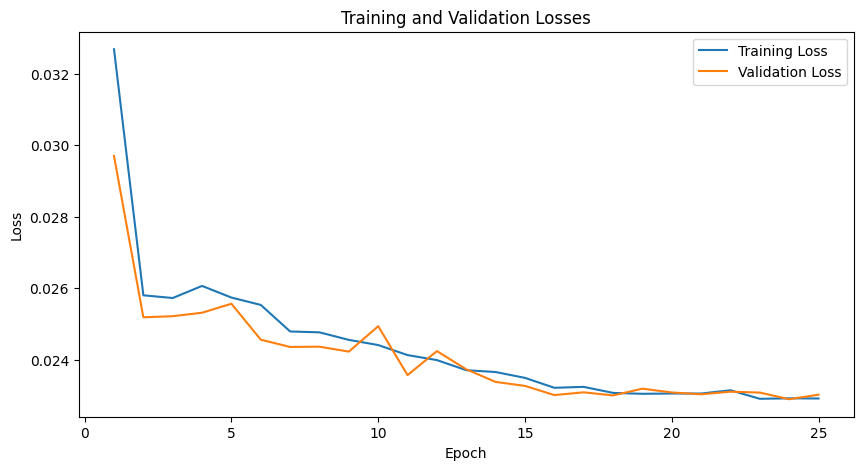

Mean Absolute Error:
CL: 0.1023
CD: 0.0076
CM: 0.0143


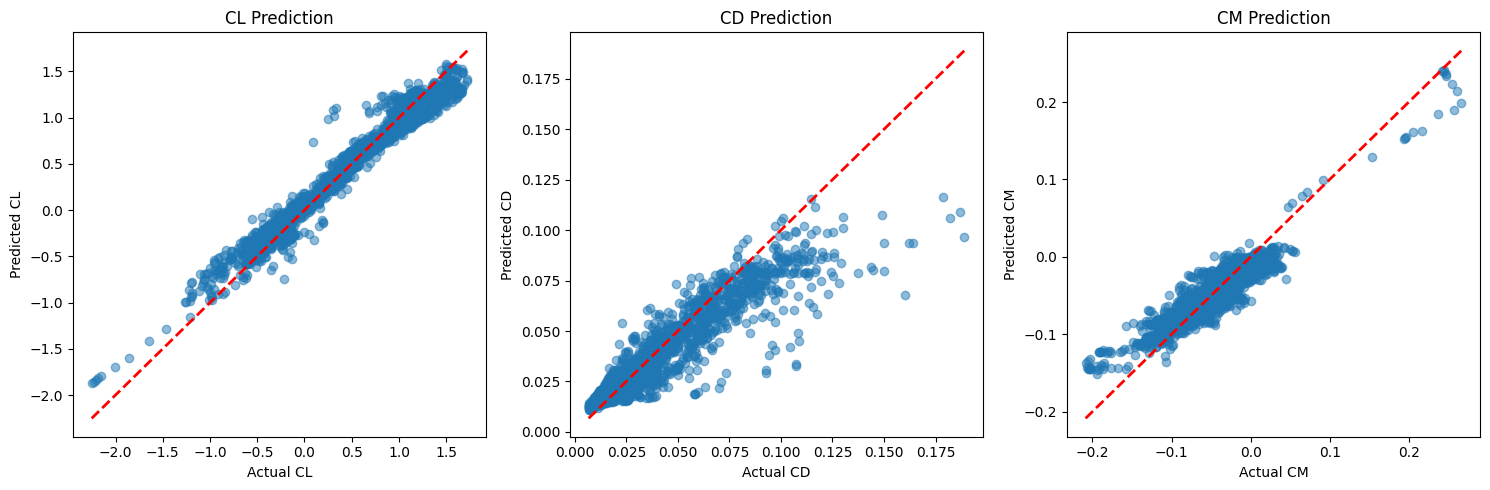

In [ ]:
if __name__ == "__main__":
    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 26), train_losses, label='Training Loss')
    plt.plot(range(1, 26), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

    # Model Evaluation
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, params, targets in val_loader:
            inputs, params, targets = inputs.to(device), params.to(device), targets.to(device)
            outputs = model(inputs, params)
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    # Denormalize predictions and targets
    all_predictions_denorm = dataset.output_scaler.inverse_transform(all_predictions)
    all_targets_denorm = dataset.output_scaler.inverse_transform(all_targets)

    # Calculate and print mean absolute error for each coefficient
    mae = np.mean(np.abs(all_predictions_denorm - all_targets_denorm), axis=0)
    print("Mean Absolute Error:")
    print(f"CL: {mae[0]:.4f}")
    print(f"CD: {mae[1]:.4f}")
    print(f"CM: {mae[2]:.4f}")

    # Plot predicted vs actual values for each coefficient
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    coeffs = ['CL', 'CD', 'CM']

    for i, ax in enumerate(axs):
        ax.scatter(all_targets_denorm[:, i], all_predictions_denorm[:, i], alpha=0.5)
        ax.plot([all_targets_denorm[:, i].min(), all_targets_denorm[:, i].max()],
                [all_targets_denorm[:, i].min(), all_targets_denorm[:, i].max()],
                'r--', lw=2)
        ax.set_xlabel(f'Actual {coeffs[i]}')
        ax.set_ylabel(f'Predicted {coeffs[i]}')
        ax.set_title(f'{coeffs[i]} Prediction')

    plt.tight_layout()
    plt.show()

In [ ]:
# Calculate RMSE for regression model
rmse_nn = np.sqrt(mean_squared_error(all_targets_denorm, all_predictions_denorm))
rmse_nn

0.08029559